# Project 1: Cyclic Coordinate Descent for Regularized Logistic Regression

## Datasets

dataset1

dataset2

dataset3

dataset4

dataset_synthetic

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [9]:
from scipy.special import expit  # Sigmoid function
class LogRegCCD(): 
    """
    **DESCRIPTION**
    """


    def __sigmoid(self, x): 
            return 1 / (1 + np.exp(-x))

    def fit(self, X_train, y_train, lambda_=0.01): 
        def compute_cost(X_train, y_train, lambda_):
            n = len(y_train)
            y_dash = X_train @ self.beta + self.beta_zero
            p = self.__sigmoid(y_dash)
            cost = - (1/n) * np.sum(y_train * np.log(p) + (1 - y_train) * np.log(1 - p))
            reg_term = lambda_ * np.sum(np.abs(self.beta)) / n  # L1 regularization
            return cost + reg_term
        
        def soft_threshold(a, b):
            return np.sign(a) * np.maximum(np.abs(a) - b, 0)
                  
        def calculate_coordinate_descent(X_train, y_train, lambda_, j): 
            y_dash = X_train @ self.beta + self.beta_zero
            p = self.__sigmoid(y_dash)
            p = np.clip(p, 1e-5, 1 - 1e-5)
            w = p * (1 - p)
            z = y_dash + (y_train - p) / w
            self.beta_zero = np.sum(w * z) / np.sum(w)

            residual = z - y_dash + self.beta[j] * X_train.iloc[:, j]
            st_nom = np.sum(w * X_train.iloc[:, j] * residual)

            st_denom = np.sum(w * X_train.iloc[:, j] ** 2)

            return soft_threshold(st_nom, lambda_)/st_denom
        
        g = X_train.shape[1]
        nr_iter = 100
        self.beta_zero = 0
        self.beta = np.zeros(g)

        training_data = []

        for step in range(nr_iter): 
            for j in range(g): 
                beta_j = calculate_coordinate_descent(X_train, y_train, lambda_, j)
                self.beta[j] = beta_j
            cost = compute_cost(X_train, y_train, lambda_)
            training_data.append([step, cost, self.beta_zero] + self.beta.tolist())

        columns = ["Step", "Cost", "Intercept"] + [f"Beta_{i}" for i in range(g)]
        self.training_df = pd.DataFrame(training_data, columns=columns)
        return self




    def validate(self, X_valid, y_valid, measure): 
        """
        **DESCRIPTION**

        Parameters
        ----------
        X_valid:

        y_valid:

        measure: 

        Returns
        -------
        

        """
        # TODO include lambda optimization in validation, output only scores for best results
        
        # Get predicted probabilities
        y_prob = self.predict_proba(X_valid)

        # Convert probabilities to binary predictions 
        y_pred = (y_prob >= 0.5).astype(int)

        # Compute the performance measure
        score = measure(y_valid, y_pred)
        return score

    def predict_proba(self, X_test): 
        """
        **DESCRIPTION**

        Parameters
        ----------
        X_test: 

        Returns
        -------
        

        """
        return self.__sigmoid(X_test.dot(self.beta) + self.beta_zero)
        

    def fit_optimize_lambda(self, X_train, y_train, X_valid=None, y_valid=None, measure=accuracy_score, eps=0.001, K=10):
        
        if X_valid is None and y_valid is None:
            X_valid = X_train
            y_valid = y_train

        n = len(y_train)
        # Compute lambda_max = max_l |<x_l, y>| / n (from paper)

        inner_products = np.abs(np.dot(X_train.T, y_train)) / n
        lambda_max = inner_products.max()
        lambda_min = eps * lambda_max
        
        lambdas = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_min), K))
        
        lambdas_coeffs = []
        scores = []
        
        for lam in lambdas:
            self.fit(X_train, y_train, lambda_=lam)
            coeffs = [self.beta_zero] + self.beta.tolist()
            lambdas_coeffs.append(coeffs)
            score = self.validate(X_valid, y_valid, measure)
            scores.append(score)
        
        p = X_train.shape[1]
        columns = ["Intercept"] + [f"Beta_{i}" for i in range(p)]
        self.coeffs_df = pd.DataFrame(lambdas_coeffs, columns=columns)
        self.coeffs_df['Lambda'] = lambdas
        self.coeffs_df['ValidationScore'] = scores
        
        # best score
        best_idx = np.argmax(scores)
        best_lambda = lambdas[best_idx]
        best_score = scores[best_idx]
        return best_lambda, best_score

    def plot_coeff(self, X_train, y_train, eps=0.001, K=10):
        """
        Plot the coefficient values vs. log(Lambda)
        """
        self.fit_optimize_lambda(X_train, y_train, eps=eps, K=K)
        
        plt.figure(figsize=(10, 6))
        log_lambda = np.log(self.coeffs_df['Lambda'])

        for col in self.coeffs_df.columns:
            if col not in ['Lambda', 'ValidationScore']:
                plt.plot(log_lambda, self.coeffs_df[col], marker='o', color='blue', linewidth=1)
        plt.xlabel("log(Lambda)")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient values vs. log(Lambda)")
        plt.tight_layout()
        plt.show()

    def plot_score(self, X_train, y_train, X_valid=None, y_valid=None, measure=accuracy_score, eps=0.001, K=10):
        """
        Runs fit_optimize_lambda with the provided measure, then plots the validation score vs. log(Lambda).
        """
        best_lambda, best_score = self.fit_optimize_lambda(X_train, y_train, X_valid, y_valid, measure, eps, K)
        
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(self.coeffs_df['Lambda']), self.coeffs_df['ValidationScore'],
                 marker='o', color='blue', linewidth=2)
        plt.xlabel("log(Lambda)")
        plt.ylabel("Validation Score")
        plt.title("Validation Score vs. log(Lambda)\nBest lambda: {:.4f} with score {:.4f}".format(best_lambda, best_score))
        plt.tight_layout()
        plt.show()
        
        return best_lambda, best_score



## dataset1

In [10]:
tecator_data = pd.read_csv("data/tecator.csv", header=None)
tecator_X = tecator_data.iloc[:, :-1]
tecator_y = (tecator_data.iloc[:, -1] == 'P').astype(int)

print(tecator_X.shape)
print("Target distribution (P as 1, N as 0):", sum(tecator_y) / len(tecator_y))
print(tecator_X.head())


(240, 124)
Target distribution (P as 1, N as 0): 0.425
       0        1        2        3        4        5        6        7    \
0  2.61776  2.61814  2.61859  2.61912  2.61981  2.62071  2.62186  2.62334   
1  2.83454  2.83871  2.84283  2.84705  2.85138  2.85587  2.86060  2.86566   
2  2.58284  2.58458  2.58629  2.58808  2.58996  2.59192  2.59401  2.59627   
3  2.82286  2.82460  2.82630  2.82814  2.83001  2.83192  2.83392  2.83606   
4  2.78813  2.78989  2.79167  2.79350  2.79538  2.79746  2.79984  2.80254   

       8        9    ...       114       115       116       117       118  \
0  2.62511  2.62722  ...  0.296029  0.233876  0.899661 -0.042006  0.708717   
1  2.87093  2.87661  ... -0.454959 -0.195980 -0.046359 -0.634996 -0.354403   
2  2.59873  2.60131  ...  0.628166  0.795466  0.762246 -1.268580  0.690588   
3  2.83842  2.84097  ...  0.281853  0.616500 -0.388684 -2.068390  1.276160   
4  2.80553  2.80890  ...  0.703580 -1.095540 -1.348450  0.453559  0.402624   

        119  

In [11]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(tecator_X, tecator_y)

print("Beta: ", logRegCCD.beta)
print("Beta zero: ", logRegCCD.beta_zero)

print("-----------------")

print("Accuracy score: ", logRegCCD.validate(tecator_X, tecator_y, accuracy_score))
print("Precision score: ", logRegCCD.validate(tecator_X, tecator_y, precision_score))
print("Recall score: ", logRegCCD.validate(tecator_X, tecator_y, recall_score))
print("F-measure score: ", logRegCCD.validate(tecator_X, tecator_y, f1_score))
print("Balanced Accuracy score: ", logRegCCD.validate(tecator_X, tecator_y, balanced_accuracy_score))
print("AUC-ROC score: ", logRegCCD.validate(tecator_X, tecator_y, roc_auc_score))
print("AUC-PR: score: ", logRegCCD.validate(tecator_X, tecator_y, average_precision_score))

Beta:  [-1.58622412e+04  5.65186189e+03  3.10856658e+03  2.14896774e+03
 -5.39151041e+03 -2.31492251e+03  4.40408151e+03 -2.51458768e+03
 -2.56769431e+04  2.68498391e+04  1.32244660e+04  1.22966260e+04
 -2.86072178e+04 -7.41560775e+03  8.21915029e+03  1.80290814e+04
 -1.39932427e+04 -3.04736791e+04  1.92542717e+04  1.78655716e+04
  9.99802565e+02 -7.34537729e+03 -2.55373511e+04  1.56191868e+04
  2.39359488e+04 -2.61365633e+04  1.49186436e+04 -1.44612354e+04
  1.14524557e+04  1.31228647e+04 -1.93349288e+04 -1.98753863e+04
  1.86865087e+04  1.49606853e+04 -1.65070932e+04  1.31264460e+04
  2.32890737e+03 -1.10769209e+04  8.49491579e+03 -1.17267453e+04
  8.34573819e+03 -1.55844913e+04  1.54408141e+04  7.90645537e+03
 -5.62877933e+03 -2.60063718e+04  2.25057069e+04 -1.43033643e+03
 -7.86101727e+03  1.01864043e+04  4.53948120e+03 -1.11962196e+04
 -5.99805861e+03  4.09184446e+03  1.49508317e+04  6.66968533e+03
 -2.06036553e+04 -7.41245740e+03  9.94320870e+03  1.54536535e+04
 -1.24827471e+04 -

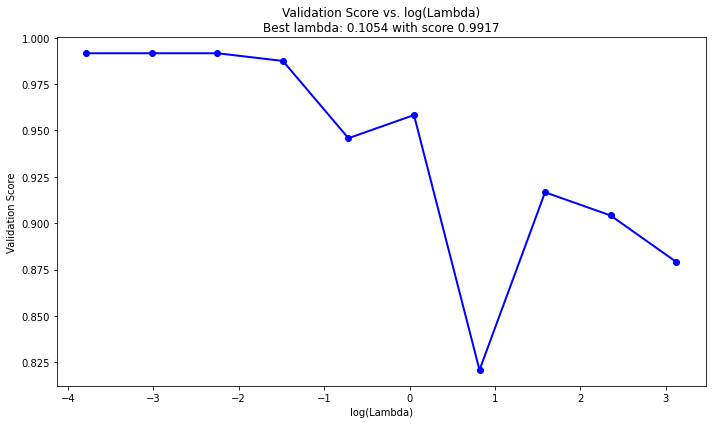

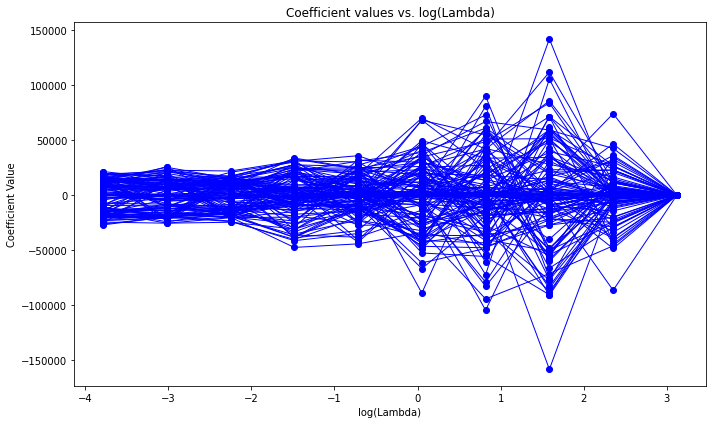

In [12]:
logRegCCD.plot_score(tecator_X, tecator_y, K=10, measure = accuracy_score)
logRegCCD.plot_coeff(tecator_X, tecator_y, K=10)

## dataset2

In [20]:
sonar_data = pd.read_csv("data/sonar.csv", header=None)
sonar_X = sonar_data.iloc[:, :-1]
sonar_y = (sonar_data.iloc[:, -1] == 'Mine').astype(int)

print(sonar_X.shape)
print("Target distribution:", sum(sonar_y) / len(sonar_y))
print(sonar_X.head())

(208, 60)
Target distribution: 0.5336538461538461
       0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      50      51      52      53      54      55      56  \
0  0.2111  ...  0.0232  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180   
1  0.2872  ...  0.0125  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140   
2  0.6194  ...  0.0033  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316   
3  0.1264  ...  0.0241  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050   
4  0.4459  ...  0.0156  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072   

       57      58      59  
0  0.0084  0.0

In [21]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(sonar_X, sonar_y)

print("Beta: ", logRegCCD.beta)
print("Beta zero: ", logRegCCD.beta_zero)

print("-----------------")

print("Accuracy score: ", logRegCCD.validate(sonar_X, sonar_y, accuracy_score))
print("Precision score: ", logRegCCD.validate(sonar_X, sonar_y, precision_score))
print("Recall score: ", logRegCCD.validate(sonar_X, sonar_y, recall_score))
print("F-measure score: ", logRegCCD.validate(sonar_X, sonar_y, f1_score))
print("Balanced Accuracy score: ", logRegCCD.validate(sonar_X, sonar_y, balanced_accuracy_score))
print("AUC-ROC score: ", logRegCCD.validate(sonar_X, sonar_y, roc_auc_score))
print("AUC-PR: score: ", logRegCCD.validate(sonar_X, sonar_y, average_precision_score))

Beta:  [   12278.43147567   136667.84479411   -93791.46972835    68327.11141205
    21582.18895696   -69664.01364245    10069.06732087  -179679.55724057
   176190.52954213   -86290.3190165     62378.22643308    59745.66055758
    17696.52030371   -25504.14031009    -4767.31171081   -17690.35648975
   -25174.54405944    42571.05479334   -65868.08885943   101662.92567611
  -113983.95971357    98589.89747795   -68464.55886183    75402.95144716
   -39541.76979138    24796.11001256   -41138.78455281     4826.99074005
    12342.06361613     4130.85028615   -57772.43687827   -23130.33797514
   104337.65751869  -125525.10320387   106549.76738512  -124327.64622398
    52063.70163259  -113165.70511626   178110.74284646  -204392.25683436
   181495.86374179  -194683.80889795   166603.60927254  -107591.78687581
   158390.62156666   -65400.58532264    59823.24126103   116207.63507404
   416345.23159056 -1102625.64737709   140883.19213644   117175.62731835
   596945.45168208   267576.42076173  -42042

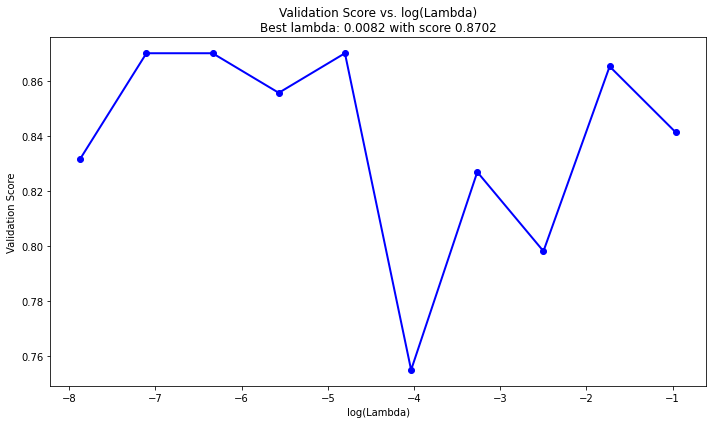

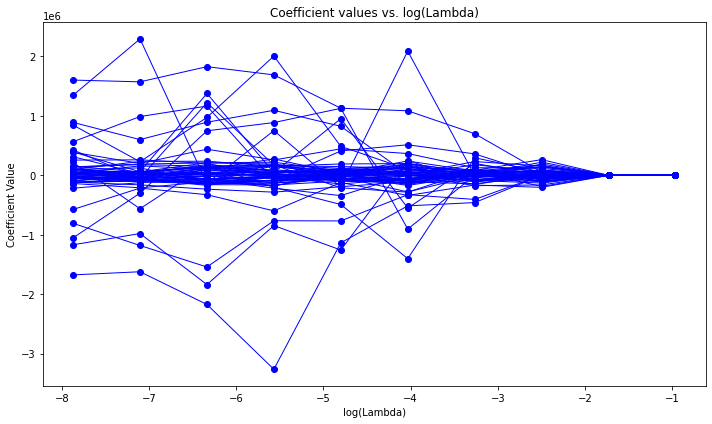

In [24]:
logRegCCD.plot_score(sonar_X, sonar_y, K=10, measure = accuracy_score)
logRegCCD.plot_coeff(sonar_X, sonar_y, K=10)

In [ ]:
# what a weird plots

## dataset3

## dataset4

## Synthetic dataset

In [3]:
def generate_synthetic_data(p, n, d, g):
    """
    Generate a synthetic dataset based on the given parameters.
    
    Parameters
    ----------
        p: float
            Prior probability for class Y=1.
        n: int
            Number of observations.
        d:  int
            Dimensionality of feature space.
        g: float 
            Covariance decay factor.
    
    Returns
    ----------
        DataFrame: A DataFrame containing generated features and class labels.
    """
    
    # Generate binry class variable
    y = np.random.binomial(1, p, size=n)

    # Define means for multivariate normal distribution
    mean_0 = np.zeros(d)
    mean_1 = np.array([1 / (i + 1) for i in range(d)])

    # Define covariance matrix S
    indices = np.arange(d)
    S = np.array([[g ** np.abs(i - j) for j in indices] for i in indices])
    
    # Create DataFrame
    X = np.array([
        np.random.multivariate_normal(mean_1 if y_id == 1 else mean_0, S)
        for y_id in y
    ])
    columns = [f'X{i+1}' for i in range(d)]
    X = pd.DataFrame(X, columns=columns)
    
    return X, y


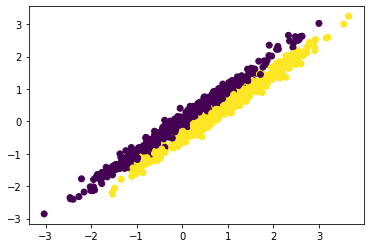

In [25]:
np.random.seed(42)
p = 0.5
n = 1000
d = 2
g = 0.99

synthetic_X, synthetic_y = generate_synthetic_data(p, n, d, g)
plt.scatter(synthetic_X["X1"], synthetic_X["X2"], c=synthetic_y)
plt.show()

Beta:  [ 8.19317163 -7.94305664]
Beta zero:  -0.9991137865733145
-----------------
Accuracy score:  0.909
Precision score:  0.8464163822525598
Recall score:  0.9979879275653923
F-measure score:  0.9159741458910434
Balanced Accuracy score:  0.9095307431067519
AUC-ROC score:  0.9095307431067517
AUC-PR: score:  0.8457133311816291


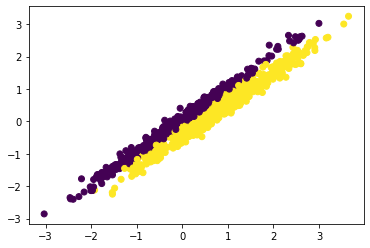

In [65]:
# synthetic_X = pd.DataFrame(StandardScaler().fit_transform(synthetic_X))

logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(synthetic_X, synthetic_y)
# Get predicted probabilities
y_prob_syn = logRegCCD.predict_proba(synthetic_X)

print("Beta: ", logRegCCD.beta)
print("Beta zero: ", logRegCCD.beta_zero)

print("-----------------")

print("Accuracy score: ", logRegCCD.validate(synthetic_X, synthetic_y, accuracy_score))
print("Precision score: ", logRegCCD.validate(synthetic_X, synthetic_y, precision_score))
print("Recall score: ", logRegCCD.validate(synthetic_X, synthetic_y, recall_score))
print("F-measure score: ", logRegCCD.validate(synthetic_X, synthetic_y, f1_score))
print("Balanced Accuracy score: ", logRegCCD.validate(synthetic_X, synthetic_y, balanced_accuracy_score))
print("AUC-ROC score: ", logRegCCD.validate(synthetic_X, synthetic_y, roc_auc_score))
print("AUC-PR: score: ", logRegCCD.validate(synthetic_X, synthetic_y, average_precision_score))

y_pred_syn = (y_prob_syn >= 0.5).astype(int)
plt.scatter(synthetic_X.iloc[:,0], synthetic_X.iloc[:,1], c=y_pred_syn)
plt.show()

Accuracy:  1.0
Beta:  [[ 18.55253214 -18.164251  ]]
Beta zero:  [-4.72283553]


C:\Users\kubas\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


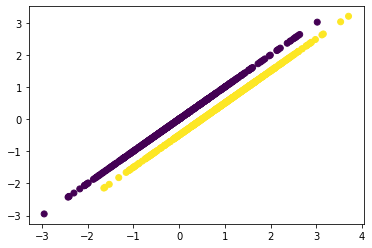

In [6]:
clf = LogisticRegression(random_state=42, penalty='l1', solver='saga').fit(synthetic_X, synthetic_y)
print("Accuracy: ", clf.score(synthetic_X, synthetic_y))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)
y_pred_lg = clf.predict(synthetic_X)
plt.scatter(synthetic_X.iloc[:,0], synthetic_X.iloc[:,1], c=y_pred_lg)
plt.show()

In [25]:
logRegCCD.plot_score(synthetic_X, synthetic_y, K=10, measure = accuracy_score)
logRegCCD.plot_coeff(synthetic_X, synthetic_y, K=10)

NameError: name 'synthetic_X' is not defined

## predict_students_dropout_and_academic_success

In [8]:
student_dropout_X = pd.read_csv("./data/predict_students_dropout_and_academic_success/data.csv", sep=";")
student_dropout_y = (student_dropout_X['Target'] == 'Graduate').astype(int)
student_dropout_X.drop("Target", inplace=True, axis=1)
print(student_dropout_X.shape)
print("Graduated: ", sum(student_dropout_y)/len(student_dropout_y))
student_dropout_X.head()

(4424, 36)
Graduated:  0.4993218806509946


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


In [72]:
logRegCCD = LogRegCCD()
logRegCCD = logRegCCD.fit(student_dropout_X, student_dropout_y)

print("Beta: ", logRegCCD.beta)
print("Beta zero: ", logRegCCD.beta_zero)

print("-----------------")

print("Accuracy score: ", logRegCCD.validate(student_dropout_X, student_dropout_y, accuracy_score))
print("Precision score: ", logRegCCD.validate(student_dropout_X, student_dropout_y, precision_score))
print("Recall score: ", logRegCCD.validate(student_dropout_X, student_dropout_y, recall_score))
print("F-measure score: ", logRegCCD.validate(student_dropout_X, student_dropout_y, f1_score))
print("Balanced Accuracy score: ", logRegCCD.validate(student_dropout_X, student_dropout_y, balanced_accuracy_score))
print("AUC-ROC score: ", logRegCCD.validate(student_dropout_X, student_dropout_y, roc_auc_score))
print("AUC-PR: score: ", logRegCCD.validate(student_dropout_X, student_dropout_y, average_precision_score))

Beta:  [ 1.03648873e-02 -6.16483330e-03 -4.09818832e-02 -2.11705830e-04
 -3.41234661e-01  1.59195365e-02 -3.67028015e-03 -2.82049552e-02
  2.26326902e-03  4.49835659e-03  6.13119028e-03 -5.92646623e-03
 -2.23934213e-04 -1.57050901e-01 -1.75727999e-01 -9.22546445e-01
  1.74695691e+00 -3.38129887e-01  6.92488533e-01 -2.79785327e-02
  1.39761822e+00 -1.36677468e-01 -2.89905311e-01 -4.05790072e-02
  6.02642024e-01  4.36477869e-03  1.01536218e-01 -9.73185567e-02
 -5.22950583e-01 -7.23237407e-02  8.12003455e-01  8.08986124e-02
  1.24285452e-01 -5.55855518e-02  1.35592808e-03 -3.01558912e-02]
Beta zero:  0.4659652825808854
-----------------
Accuracy score:  0.8474231464737794
Precision score:  0.8203842940685045
Recall score:  0.8890900860117701
F-measure score:  0.8533565066261134
Balanced Accuracy score:  0.8474795802519347
AUC-ROC score:  0.8474795802519347
AUC-PR: score:  0.784775289411515


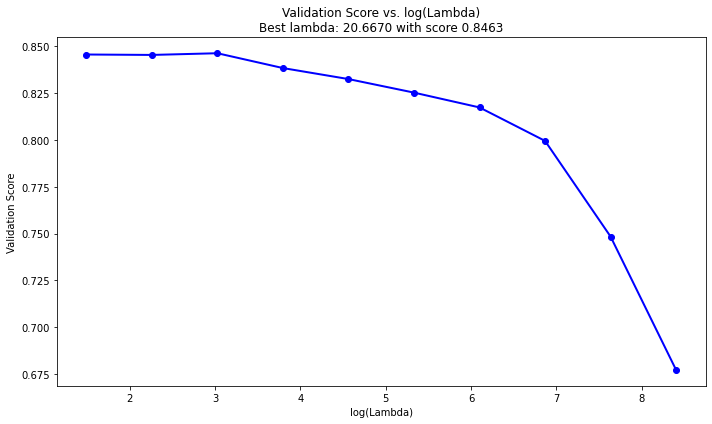

(20.667032053313765, 0.8462929475587704)

In [68]:
logRegCCD.plot_score(student_dropout_X, student_dropout_y, K=10, measure = accuracy_score)

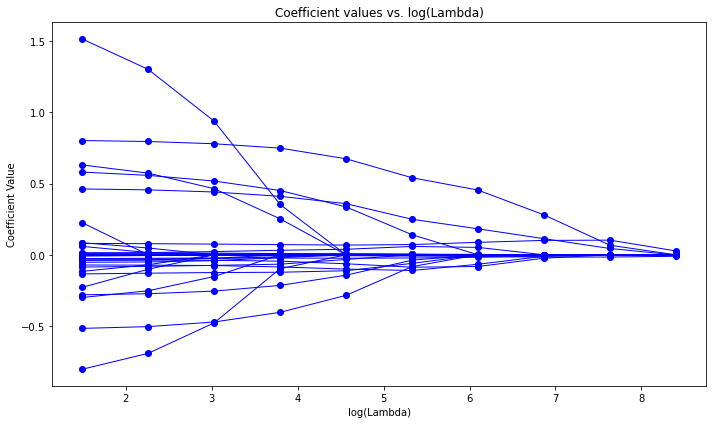

In [73]:
logRegCCD.plot_coeff(student_dropout_X, student_dropout_y, K=10)

In [70]:
logRegCCD.fit_optimize_lambda(student_dropout_X, student_dropout_y)

(20.667032053313765, 0.8462929475587704)

In [10]:
clf = LogisticRegression(random_state=42, penalty='l1', solver='saga').fit(student_dropout_X, student_dropout_y)
print("Accuracy: ", clf.score(student_dropout_X, student_dropout_y))

print("Beta: ", clf.coef_)
print("Beta zero: ", clf.intercept_)

Accuracy:  0.6618444846292948
Beta:  [[-1.72533981e-04 -1.15581938e-02  3.55333254e-04 -2.10673734e-05
   7.82439004e-06 -1.32316201e-03  4.58163859e-04 -6.27273025e-04
  -7.78359162e-04  7.57815295e-04 -1.18469021e-03 -8.23275428e-04
   2.05094584e-03  1.44932944e-04 -4.30626905e-06 -2.85646591e-04
   4.09042971e-04 -4.39677587e-04  5.30993111e-04 -5.86477278e-03
  -6.47016701e-07  6.46054691e-04  1.51600311e-03 -3.19549139e-04
   6.23851567e-03  7.81136841e-03 -2.06145216e-04  5.76654673e-04
   1.47959794e-03  8.58155489e-06  7.16648687e-03  9.81183195e-03
  -2.91689718e-04 -9.25804942e-05 -1.78295089e-04  3.42063790e-04]]
Beta zero:  [-3.95589641e-05]


C:\Users\kubas\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
